## Roots of non-linear functions, interpolations and more

You want a notebook, you have it.

I don't know about all these packages. I will only call the packages when we need them so you have a good idea about what we are using. Turns out we don't need many.

In [46]:

# import DelimitedFiles: writedlm, readdlm;
#import QuantEcon: MarkovChain, simulate, tauchen, gridmake;
#import Formatting: printfmt;
#import Random: seed!;
#import Optim: optimize, minimizer;
#using UnPack;

#using StatsBase;
#using Roots;



In [47]:
using Plots
using LinearAlgebra

### Step 1: Create a function and plot it.

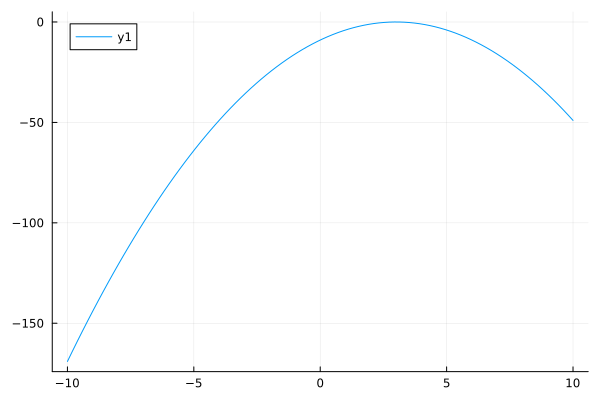

In [48]:
# GOAL
# I'm trying to see if I can approximate a function using the CompEcon package
# and use the approximations in a nonlinear solver. 

################################################################################
# Step 1: Create a function and plot it.
# A simple function of one variable and one parameter
function f(x, p)
    return -(x .- p) .^ 2;
end

x = collect(range(-10, 10, length=100));
fx = f(x, 3);
Plots.plot(x, fx)

Xing's note: Global variables cause performance issues in Julia. You can use a named tuple or struct.

Define a named tuple. You can see I also defined the function inside the tuple.

I will focus on the case where p being a vector, so we are solving a system of non-linear equations, as is common in economic applications.

In [49]:
"""
Create an instance of the model, stored as a namedtuple.

"""
function create_showcase_model(; xmin = -10.0, #beware of type
                                 xmax = 10.0,
                                 nx = 100,
                                 p = [3.0, 4.0])
        x_grid = LinRange(xmin, xmax, nx)
        f(x, p) = - (x .- p) .^ 2  
        return (; x_grid, f, p, nx)
end

create_showcase_model

In [50]:
# create the tuple 
model = create_showcase_model()

# want to change some parameter? do
# create_showcase_model(p = 4.0)

(x_grid = LinRange{Float64}(-10.0, 10.0, 100), f = var"#f#37"(), p = [3.0, 4.0], nx = 100)

### Step 2: Non-linear solver for zero of the function

The key here is for Newton Method we need analytical or numerical first derivative of the function. For functions (or systems) that have an analytical form, you can automatically compute the first derivative by using the ```ForwardDiff``` package. 

``` 
    fp = x -> f(x,p) # change f into a one input funcion
    autodiff(fp) = x -> ForwardDiff.jacobian(fp, x) # automatic differentiation of f
```
(Note: For a single output function, simply use ```ForwardDiff.derivative```. Here since I made f multi-variable. I use ```ForwardDiff.jacobian``` instead. )

Then I use ```fp``` and ```autodiff(fp)``` to get the Jacobian at our guesses and update it with the standard Newton method rule. 

In [51]:
# Import the package to perform automatic differentiation (you might need to Pkg.add this)
using ForwardDiff

In [52]:
function Newton(f;p = model.p, tol = 1e-8, maxiter = 1000)
    x0 = zeros(eltype(p), length(p)) #initial guesses at 0.0
    x1 = similar(x0)
    fp = x -> f(x,p) # change f into a one input funcion
    # automatic differentiation of f
    autodiff(fp) = x -> ForwardDiff.jacobian(fp, x)
    
    iter = 0
    error = 1.0
    while (error > tol && iter < maxiter)
        # not the most efficient but clear
        J = autodiff(fp)(x0) 
        x1 = x0 .- J\fp(x0) #or use a linear solver
        error = maximum(abs.(x1 - x0))
        iter += 1
        x0 .= x1
    end

    return x1
end


Newton (generic function with 1 method)

In [53]:
Newton(f)

2-element Vector{Float64}:
 2.9999999944120646
 3.9999999925494194

In [54]:
using BenchmarkTools

In [55]:
@benchmark Newton(f)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  55.667 μs …   4.811 ms  ┊ GC (min … max): 0.00% … 97.19%
 Time  (median):     57.292 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   61.743 μs ± 132.590 μs  ┊ GC (mean ± σ):  6.00% ±  2.76%

    ▆▅▆█▇▆                                                      
  ▂▆███████▆▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  55.7 μs         Histogram: frequency by time         71.7 μs <

 Memory estimate: 36.48 KiB, allocs estimate: 671.

This is an idea of what is behind the nonlinear solvers of Julia. Of course they further optimized the code to make it more efficient. 

The code you gave me utilized the ```NonlinearSolve``` package, which automatically calculates the analytical derivative of f to compute the root.

In [56]:
using NonlinearSolve, StaticArrays

In [57]:
x0 = @SVector[0.0, 0.0]
prob = NonlinearProblem(model.f, x0, model.p)
sol = solve(prob, NewtonRaphson(), reltol=1e-8)

u: 2-element SVector{2, Float64} with indices SOneTo(2):
 2.999999999999318
 3.9999999999990905

Let's look at its performance.

In [58]:
@benchmark solve(prob, NewtonRaphson(), reltol=1e-8)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  27.375 μs …  4.093 ms  ┊ GC (min … max): 0.00% … 97.44%
 Time  (median):     29.250 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   32.481 μs ± 98.394 μs  ┊ GC (mean ± σ):  7.30% ±  2.39%

   ▂▇█▄▆▆▂▂                                                    
  ▂████████▇▅▄▄▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  27.4 μs         Histogram: frequency by time          46 μs <

 Memory estimate: 26.86 KiB, allocs estimate: 275.

An alternative (which I will show is a better option) is to use the ```NLsolve``` package. The naive implementation of it uses numerical Jacobian by finite differencing.

In [59]:
using NLsolve

In [60]:
p = [3.0, 4.0]
fp = x -> f(x,p) # change f into a one input funcion
# Newton method with numerical Jacobian by finite differencing
nlsolve(fp, [0.0, 0.0]) #[0.0, 0.0] is the initial guess

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0]
 * Zero: [2.999945851229831, 3.9999278016397692]
 * Inf-norm of residuals: 0.000000
 * Iterations: 19
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 20
 * Jacobian Calls (df/dx): 20

In [61]:
@benchmark nlsolve(fp, [0.0, 0.0]) 

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  27.417 μs …   4.187 ms  ┊ GC (min … max): 0.00% … 97.50%
 Time  (median):     28.375 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   32.343 μs ± 102.803 μs  ┊ GC (mean ± σ):  8.29% ±  2.59%

  ▂▇█▆▅▅▄▄▄▄▄▃▂▂▂▁▂▂▁ ▁                                        ▂
  ███████████████████████▇▇▇▇▇▇▆▆▅▆▄▆▅▅▆▇▆▅▆▅▅▅▄▅▅▆▄▄▄▆▅▅▅▅▄▄▄ █
  27.4 μs       Histogram: log(frequency) by time      46.2 μs <

 Memory estimate: 31.03 KiB, allocs estimate: 399.

As you can see, with even with numerical differentiation ```NLsolve``` gets similar performance as the auto differentiation method in ```NonlinearSolve```. 

How about we also use auto differentiation in ```NLsolve```?

In [62]:
nlsolve(fp, [0.0, 0.0], autodiff = :forward)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0]
 * Zero: [2.9999458512298305, 3.9999278016397737]
 * Inf-norm of residuals: 0.000000
 * Iterations: 19
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 20
 * Jacobian Calls (df/dx): 20

In [63]:
# since we have analytical f here, we can 
@benchmark nlsolve(fp, [0.0, 0.0], autodiff = :forward)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  18.583 μs …  3.982 ms  ┊ GC (min … max): 0.00% … 98.42%
 Time  (median):     19.583 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   21.557 μs ± 78.343 μs  ┊ GC (mean ± σ):  7.20% ±  1.97%

   ▂▅▇██▇▆▅▅▄▄▄▃▃▂▂                                           ▂
  ▇████████████████████▇█▇▇█▇▇▇█▇▆▆▆▆▆▅▇▆▃▆▅▃▆▅▅▅▄▁▅▆▄▅▄▅▄▅▃▅ █
  18.6 μs      Histogram: log(frequency) by time        29 μs <

 Memory estimate: 18.33 KiB, allocs estimate: 219.

Note that auto-differentiation provides better performance (more than 30% here). 

If you like algebra, you can also manually inputting the derivatives:

In [64]:
fprime(x, p) =  -2.0 * x .+ 2.0 .* p # analytical derivative
p = [3.0, 4.0]
fprime_p = x -> Diagonal(fprime(x, p)) #to create correct Jacobian

#46 (generic function with 1 method)

In [65]:
nlsolve(fp, fprime_p, [0.0, 0.0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0]
 * Zero: [2.9999458512298305, 3.9999278016397737]
 * Inf-norm of residuals: 0.000000
 * Iterations: 19
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 20
 * Jacobian Calls (df/dx): 20

In [66]:
@benchmark nlsolve(fp, fprime_p, [0.0, 0.0])

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  18.542 μs …  3.989 ms  ┊ GC (min … max): 0.00% … 98.33%
 Time  (median):     19.167 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   20.747 μs ± 67.761 μs  ┊ GC (mean ± σ):  5.59% ±  1.70%

      █▃▃                                                      
  ▂▃▇████▆▅▃▃▃▄▃▅▄▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂ ▃
  18.5 μs         Histogram: frequency by time        24.7 μs <

 Memory estimate: 17.09 KiB, allocs estimate: 235.

Surprisingly (at least to me), manually inputting the Jacobian is not faster than automatic differentiation. Maybe this will not be the case when the non-linear system becomes complicated but in such cases I won't want to compute the analytical Jacobian anyways.

Caveat: use ```NLsolve``` over ```Nonlinearsolve```  and use auto-differentiation whenever possible.

### Step 3: do linear interpolations

I will use the ```Interpolations``` package. The syntax is in a more Julia styled fashion.

In [67]:
using Interpolations

In [68]:
function lin_interp(x_grid, f, p; extrapolation = false)
    fx_value = reduce(hcat, f.(x_grid, Ref(p)))'#broadcast to get function value of every x, then turn it into the correct matrix form
    # linear interpolation
    itp = interpolate(fx_value, BSpline(Linear()))
    if extrapolation
        itp = extrapolate(itp, Reflect()) 
    end
    
    # quadratic interpolation: BSpline(Quadratic(Reflect(OnCell()))))
    # cubic interpolation: BSpline(Cubic(Line(OnGrid()))))
    
    return scale(itp, x_grid, 1:2) # linear interpolate
end

lin_interp (generic function with 1 method)

Note: ```scale``` is highly performant but only works with evenly spaced grids. If you want to deal with uneven grids, check [documentation](https://juliamath.github.io/Interpolations.jl/stable/control/#Scaled-BSplines).

To do extrapolations, just use `extrapolate(itp, Flat())`. 

Another option is to use this one line code ```linear_interpolation(x_grid, fx,extrapolation_bc=Line()) ```. This is very general as you can put arbitrary grids. It will return results for linear interpolations and extrapolations at the same time, but is less efficient.

In [69]:
itp = lin_interp(model.x_grid, model.f, model.p)
# wrap it into a function of x 
itp_func = x -> diag(itp(x, 1:2)')
# need to do this to let Julia interpret it as a two output function correctly
# I know it is not so intuitive here. With non-linear systems we don't need to do this

#49 (generic function with 1 method)

### Step 4: Use the interpolated function to find the zero. 

In [70]:
nlsolve(itp_func, [0.0, 0.0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0]
 * Zero: [2.9292982449175766, 3.9421841600676806]
 * Inf-norm of residuals: 0.005000
 * Iterations: 1000
 * Convergence: false
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: false
 * Function Calls (f): 69
 * Jacobian Calls (df/dx): 17

It got close but failed to converge! How come?

Well notice this particular function's root is right at its global max. That means a linear interpolation around where the true value is can get inaccurate. 

A quadratic (or cubic) interpolation will work. Again the documentation is [here](https://juliamath.github.io/Interpolations.jl/stable/control/).

In [71]:
function spline_interp(x_grid, f, p)
    fx_value = reduce(hcat, f.(x_grid, Ref(p)))' #broadcast to get function value of every x, then turn it into the correct matrix form
    itp = interpolate(fx_value, BSpline(Quadratic(Natural(OnCell()))))
    return scale(itp, x_grid, 1:length(p)) # get all p outputs
end


spline_interp (generic function with 1 method)

In [72]:
itp_spline = spline_interp(model.x_grid, model.f, model.p)
# wrap it into a function of x 
itp_func_spline = x -> diag(itp_spline(x, 1:2)')

#51 (generic function with 1 method)

In [73]:
nlsolve(itp_func_spline, [0.0, 0.0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0]
 * Zero: [2.999945851228844, 3.999927801639262]
 * Inf-norm of residuals: 0.000000
 * Iterations: 19
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 20
 * Jacobian Calls (df/dx): 20

Nice, it converged. The accuracy is still not as good again due to the feature that root coincides with local max.

Let's look at the time of it.

In [74]:
@benchmark nlsolve(itp_func_spline, [0.0, 0.0])

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  46.333 μs …   4.464 ms  ┊ GC (min … max): 0.00% … 97.37%
 Time  (median):     48.208 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   52.173 μs ± 111.223 μs  ┊ GC (mean ± σ):  5.57% ±  2.59%

    ▅▇▆█▇▂                                                      
  ▂▆██████▇▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  46.3 μs         Histogram: frequency by time         64.1 μs <

 Memory estimate: 34.75 KiB, allocs estimate: 518.

Actually not that bad compared to linear interpolation.

Just to show that linear interpolation works properly, consider another function. I will also show how you can get its fixed point.

In [75]:
g(x, p) = exp.(-x) .- p
p = [3.0, 4.0];

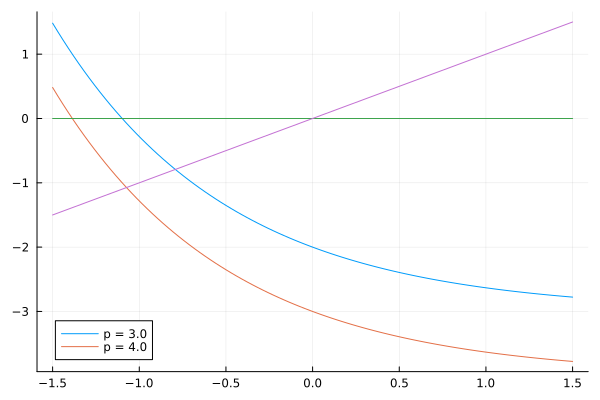

In [93]:
smallergrid = LinRange(-1.5, 1.5, 100)
plot(smallergrid, g(smallergrid, p[1]), label = "p = 3.0")
plot!(smallergrid, g(smallergrid, p[2]), label = "p = 4.0")
plot!(smallergrid, zeros(100, 1), label = "")
plot!(smallergrid, smallergrid, label = "") # plot y = x to look at the fixed point

In [77]:
# root finding without linear interpolation 
gp = x -> g(x,p) # change g into a one input funcion
# first differencing
nlsolve(gp, [0.0, 0.0], autodiff = :forward)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0]
 * Zero: [-1.0986122886681098, -1.3862943611198906]
 * Inf-norm of residuals: 0.000000
 * Iterations: 6
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 7
 * Jacobian Calls (df/dx): 7

You can also find the fixed point of it with ```fixedpoint()```. This is also hosted by the ```NLsolve``` package.

In [78]:
fixedpoint(gp, [0.0, 0.0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Anderson m=2 beta=1 aa_start=1 droptol=0
 * Starting Point: [0.0, 0.0]
 * Zero: [-0.7920599684315333, -1.0737289380016115]
 * Inf-norm of residuals: 0.000000
 * Iterations: 11
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 11
 * Jacobian Calls (df/dx): 0

In [79]:
# root finding with linear interpolation 
itp = lin_interp(model.x_grid, g, model.p; extrapolation = true) #need to allow extrapolation here otherwise it will raise an error
itp_func = x -> diag(itp(x, 1:2)')
nlsolve(itp_func, [0.0, 0.0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0]
 * Zero: [-1.0973932089692615, -1.3816279744002586]
 * Inf-norm of residuals: 0.000000
 * Iterations: 4
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 5
 * Jacobian Calls (df/dx): 5

With the ```NonlinearSolve``` package, it works with the original function.

In [80]:
x0 = @SVector[0.0, 0.0]
prob = NonlinearProblem(g, x0, model.p)
sol = solve(prob, NewtonRaphson(), reltol=1e-8)

u: 2-element SVector{2, Float64} with indices SOneTo(2):
 -1.0986122886681096
 -1.3862943611198906

Now look at the interpolated function. In won't work with the ```NonlinearSolve``` package as the package as shown below. The reason is that the package takes use of automatic differentiation, which we don't have an analytical form to do it here. Check the documentation [here](https://docs.sciml.ai/NonlinearSolve/stable/solvers/NonlinearSystemSolvers/).


In [81]:
x0 = @SVector[0.0, 0.0]
itp_func2 = x -> diag(itp(x, 1:2)')
prob = NonlinearProblem(itp_func2, x0)
sol = solve(prob, NewtonRaphson(), reltol=1e-8)

SciMLBase.TooFewArgumentsError: All methods for the model function `f` had too few arguments. For example,
an ODEProblem `f` must define either `f(u,p,t)` or `f(du,u,p,t)`. This error
can be thrown if you define an ODE model for example as `f(u,t)`. The parameters
`p` are not optional in the definition of `f`! For more information on the required
number of arguments for the function you were defining, consult the documentation
for the `SciMLProblem` or `SciMLFunction` type that was being constructed.

For example, here is the no parameter Lorenz equation. The two valid versions
are out of place:

```julia
function lorenz(u,p,t)
  du1 = 10.0*(u[2]-u[1])
  du2 = u[1]*(28.0-u[3]) - u[2]
  du3 = u[1]*u[2] - 8/3*u[3]
  [du1,du2,du3]
 end
 u0 = [1.0;0.0;0.0]
 tspan = (0.0,100.0)
 prob = ODEProblem(lorenz,u0,tspan)
```

and in-place:

```julia
function lorenz!(du,u,p,t)
  du[1] = 10.0*(u[2]-u[1])
  du[2] = u[1]*(28.0-u[3]) - u[2]
  du[3] = u[1]*u[2] - 8/3*u[3]
 end
 u0 = [1.0;0.0;0.0]
 tspan = (0.0,100.0)
 prob = ODEProblem(lorenz!,u0,tspan)
```

Offending function: f
Methods:
# 1 method for anonymous function "#57":
 [1] (::var"#57#58")(x)
     @ ~/Documents/Notes/Julia code for kim/forKim.ipynb:2


### Step 5: fixing your code

If you really like the Matlab styled code, the fix is really easy and I put it as the back. Redefine the function and use the ```NLsolve``` package, then you are good to go. However, I deliberately keep it to the end so that you can have a feeling about what more Julia styled code looks like. 

Now to run these we need all the ```Compecon``` stuff which I don't know very well.

In [82]:
import CompEcon: funfitxy, funeval, fundef, funnode, funbase, qnwnorm


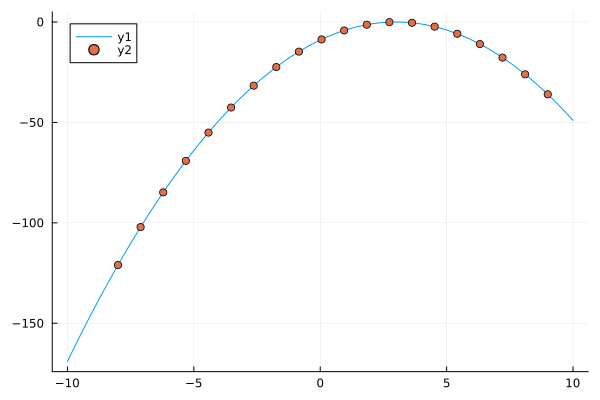

In [97]:
fx = f(x, 3);
function create_interp(minx, maxx, n, f, x)
    # Create the function space for a spline approximant over 
    # [xmin, xmax] at n points. Use a cubic spline.
    fspace = fundef([:spli, range(minx, maxx, n), 0, 3]);

    # Compute the basis coefficients for the function defined by x, f(x, p)
    # This returns a tuple whose first element is the coefficients
    c = funfitxy(fspace, x, f)[1];
    return fspace, c;
end

# Create the approximant.
# Note that fx contains the values of f(x, 3)
fspace, c = create_interp(-10, 10, 8, fx, x);

# Evaluate the approximation on some arbitrary points. 
y = funeval(c, fspace, range(-8, 9, 20))[1];

Plots.plot(x, fx)
Plots.plot!(range(-8, 9, 20), y, seriestype=:scatter)

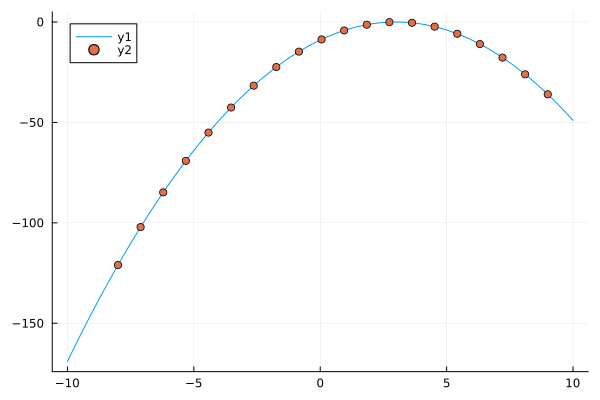

In [98]:
################################################################################
# Step 4: Use the interpolated function to find the zero. 


# Wrap the funeval to handle parameters. There are now two: the original 
# parameter and the fspace, which is needed to evaluate the approximant.
function to_max(x, paras)
    # paras[1]=c, paras[2]=fspace
    return funeval(paras[1], paras[2], x)[1]
end

# Check the to_max function. This works. 
Plots.plot(x, f(x,3))
yy = to_max(range(-8, 9, 20), [c, fspace]);
Plots.plot!(range(-8, 9, 20), yy, seriestype=:scatter)



An easy fix with the ```NLsolve``` package. What you do is wrap it into a function of x and feed it into the ```nlsolve()``` function. It will automatically take use of finite differencing to find the correct zeros. It works quite generally with non-linear systems, as discussed.

In [99]:
max_x = x -> to_max(x, [c, fspace])
nlsolve(max_x, [0.0])


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0]
 * Zero: [2.9999440511483537]
 * Inf-norm of residuals: 0.000000
 * Iterations: 18
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 19
 * Jacobian Calls (df/dx): 19

And now you know why the following doesn't work:

In [44]:
# Now, can I find the zero using the interpolated function?
# Not with my poor Julia skills. 
# It's not with your Julia skills, it is the problem with the package
# this won't work with any interpolated function as far as I know

x0 = @SVector[1];
p = [c, fspace];
prob = NonlinearProblem(to_max, x0, p)
sol = solve(prob,NewtonRaphson(),  reltol=1e-6)

BoundsError: BoundsError: attempt to access Tuple{} at index [1]